##### 백엔드 코드

In [2]:
import pandas as pd

# 데이터 불러오기 
data = pd.read_csv('datasets/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')
data.head(10)
print(data.shape)

/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/1726811543.py:4: DtypeWarning: Columns (1,2,7,11,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('datasets/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')


(2622133, 38)


In [3]:
### 데이터 파악

# 데이터 타입이 mixed 인 컬럼 : [1, 2, 7, 11, 29] 번 째 컬럼
columns = data.columns # 전체 컬럼
for column in columns:
    print(data[column].apply(type).value_counts())

# mixed 데이터 명명 
mixed_columns_index = [1, 2, 7, 11, 29]
mixed_columns_name = data.columns[mixed_columns_index]

# Major 데이터 타입 확인
for column in mixed_columns_name:
    print(data[column].apply(type).unique())
    print(data[column].apply(type).value_counts())

# Minor 데이터 정체 확인 
## 1, 'Health Service Area', 'Hospital County', 'Patient Disposition' -> 결측치 처리 필요
## 2. 'Zip Code - 3 digits' -> 환자 거주지역을 나타내는 의미없는 데이터 -> Drop 
for column in mixed_columns_name:
    not_str_index = data[column].apply(lambda x: type(x) == str)
    print(data[column][~not_str_index].value_counts(dropna=False))


index
<class 'int'>    2622133
Name: count, dtype: int64
Health Service Area
<class 'str'>      2617246
<class 'float'>       4887
Name: count, dtype: int64
Hospital County
<class 'str'>      2617246
<class 'float'>       4887
Name: count, dtype: int64
Operating Certificate Number
<class 'float'>    2622133
Name: count, dtype: int64
Facility ID
<class 'float'>    2622133
Name: count, dtype: int64
Facility Name
<class 'str'>    2622133
Name: count, dtype: int64
Age Group
<class 'str'>    2622133
Name: count, dtype: int64
Zip Code - 3 digits
<class 'str'>      2061890
<class 'int'>       524288
<class 'float'>      35955
Name: count, dtype: int64
Gender
<class 'str'>    2622133
Name: count, dtype: int64
Race
<class 'str'>    2622133
Name: count, dtype: int64
Ethnicity
<class 'str'>    2622133
Name: count, dtype: int64
Length of Stay
<class 'str'>    2523136
<class 'int'>      98997
Name: count, dtype: int64
Type of Admission
<class 'str'>    2622133
Name: count, dtype: int64
Patient Disp

In [4]:
### 데이터 전처리 - 결측치 및 비정상적인 값 처리
pd.set_option('display.max_columns', None)

# 'Length of Stay' 컬럼 처리
## 문자열 등 비정상적인 값은 NaN으로 변환
data['Length of Stay'] = pd.to_numeric(data['Length of Stay'], errors='coerce')
## NaN이 된 행은 제거
df = data.dropna(subset=['Length of Stay'])
## float → int 로 형변환 (NaN 제거되었으므로 안전)
df['Length of Stay'] = df['Length of Stay'].astype(int)

# NaN 개수가 너무 많은 컬럼 제거
## Source of Payment 2, Source of Payment 3, Operating Provider License Number, Other Provider License Number 컬럼
nan_columns = df.columns[df.isna().sum() > 10_000]
df = df.drop(columns=nan_columns)

# 의미없는 컬럼 제거 
# 'Zip Code - 3 digits'(우편번호) / 'index'(인덱스)
# 'Attending Provider License Number'(주치의 면허번호) / 'Operating Certificate Number'(운영 인증 번호)
df = df.drop(columns=['Zip Code - 3 digits', 'index', 'Attending Provider License Number', 'Operating Certificate Number'])


# 'Birth Weight' 컬럼 처리 - 컬럼 삭제
df = df.drop(columns=['Birth Weight'])
# # 'Birth Weight' 컬럼 처리 - Birth Weight = 0인 데이터 삭제
# # 삭제 전 총 데이터 수
# total_before = len(df)
# # 'Birth Weight' 컬럼값이 0인 데이터 삭제
# df = df[df['Birth Weight'] != 0]
# # 삭제 후 총 데이터 수
# total_after = len(df)
# # 삭제된 데이터 수
# deleted_rows = total_before - total_after
# # 결과 출력
# print(f"삭제 전 데이터 수: {total_before}")
# print(f"삭제 후 데이터 수: {total_after}")
# print(f"'Birth Weight' 값이 0인 데이터 개수(삭제된 행 수): {deleted_rows}")

/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/1815843966.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Length of Stay'] = df['Length of Stay'].astype(int)


In [40]:
# ### 데이터 전처리 - 이상치 처리 
from packages.category_utils import preview_rare_categories, replace_and_report_rare_categories
from packages.number_utils import plot_zscore_outliers_all, remove_zscore_outliers_all
import pandas as pd

num_columns = ['Total Charges', 'Total Costs', 'Length of Stay']#, 'Birth Weight']
cate_columns = [col for col in df.columns
               if col not in num_columns + ['Patient Disposition']]

# # 수치형 컬럼의 이상치 여부를 확인하고, 이상치를 제거합니다.
# bins = [1000, 1000, 80]#, 100]

# ## 1) 이상치 시각화
# plot_zscore_outliers_all(df, columns=num_columns, bins_list=bins, z_thresh=2)

# ## 2) 이상치 제거
# df_num_clean = remove_zscore_outliers_all(df, columns=num_columns, z_thresh=2)



# # 범주형 컬럼의 이상치 여부를 확인하고, 이상치를 Others로 대체합니다.

# ## 1) 이상치 시각화
# rare_info = preview_rare_categories(df, columns=cate_columns, threshold=0.01)
# print(rare_info)

# ## 2) 이상치 대체
# df_cate_clean = replace_and_report_rare_categories(df,cate_columns)

# # df = pd.concat([df_cate_clean, df_num_clean, df['Patient Disposition']], axis=1)

In [43]:
### 모델 선정 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# -------------------------------
# 대략적인 모델별 성능 비교
# -------------------------------

# -------------------------------
# 공통 전처리 파이프라인 구성
# -------------------------------
# 범주형 데이터 전처리 - Tree based 모델(DecisionTree, RandomForest, XGBoost 등) + Support Vector 모델 
cat_pipeline = make_pipeline( 
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)
# 범주형 데이터 전처리 - 비 Tree based 모델(LogisticRegression 등)
cat2_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)
# 연속형 데이터 전처리
num_pipeline = make_pipeline(
    KNNImputer(n_neighbors=5),
    StandardScaler()
)
# 파이프라인 - Tree based 모델(DecisionTree, RandomForest, XGBoost 등) + Support Vector 모델 
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cate_columns),
    ('num', num_pipeline, num_columns)
])
# 파이프라인 - 비 Tree based 모델(LogisticRegression 등)
preprocessor2 = ColumnTransformer([
    ('cat', cat2_pipeline, cate_columns),
    ('num', num_pipeline, num_columns)
])
# PCA - SVC 모델에만 적용
pca = PCA(n_components=3)
# SMOTE - 오버 샘플링 기법
smote = SMOTE(k_neighbors=3, sampling_strategy=0.3, random_state=42)

# -------------------------------
# 데이터 분할
# -------------------------------

# 이진 분류 문제로 변환 
X = df.drop(columns=['Patient Disposition'])

disposition_evasion = [
    "Left Against Medical Advice"
]

# 이탈이면 1, 아니면 0으로 이진화
y = np.where(df['Patient Disposition'].isin(disposition_evasion), 1, 0)

# 데이터 셋 분할 
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.01, test_size=0.002, random_state=42, stratify=y)


# -------------------------------
# 사용할 회귀 모델 정의
# -------------------------------
models = {
    'LogisticRegression' : LogisticRegression(),
    'KNNNeighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    # 'Support Vector Classifier': SVC(probability=True)
}

# -------------------------------
# 모델 학습 및 성능 비교
# -------------------------------

results = []
print("="*20, "이진 분류 모델 성능 비교", "="*20)
for name, model in models.items():

    # 레이블 인코딩을 사용하는 모델
    if name in ['KNNNeighbors', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']:
        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('model', model)
        ])
    # SVC 모델 - PCA 적용
    elif name == 'Support Vector Classifier':
        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('pca', pca),
        ('model', model)
        ])
    # LogisticRegression 모델 - OneHotEncoding 적용
    else:
        pipeline = Pipeline([
        ('preprocessor', preprocessor2),
        ('smote', smote),
        ('model', model)
        ])

    # 모델 학습
    pipeline.fit(X_train, y_train)
    # 모델 예측
    y_pred_proba = pipeline.predict_proba(X_test)
    # Threshold : 0.5
    y_pred = np.where(y_pred_proba[:, 1] > 0.5, 1, 0)

    # 평가지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # 결과 저장
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"[{name}] Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

==================== 이진 분류 모델 성능 비교 ====================
[LogisticRegression] Accuracy: 0.9445, Precision: 0.2079, Recall: 0.5526, F1 Score: 0.3022
[KNNNeighbors] Accuracy: 0.9338, Precision: 0.1415, Recall: 0.4035, F1 Score: 0.2096
[Decision Tree] Accuracy: 0.9655, Precision: 0.2624, Recall: 0.3246, F1 Score: 0.2902
[Random Forest] Accuracy: 0.9842, Precision: 1.0000, Recall: 0.2719, F1 Score: 0.4276
[Gradient Boosting] Accuracy: 0.9838, Precision: 0.9677, Recall: 0.2632, F1 Score: 0.4138
[XGBoost] Accuracy: 0.9840, Precision: 0.8571, Recall: 0.3158, F1 Score: 0.4615


In [45]:
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')
results_df

,Accuracy,Precision,Recall,F1 Score
Model,,,,
LogisticRegression,0.944466,0.207921,0.552632,0.302158
KNNNeighbors,0.933779,0.141538,0.403509,0.209567
Decision Tree,0.965458,0.262411,0.324561,0.290196
Random Forest,0.984160,1.000000,0.271930,0.427586
Gradient Boosting,0.983779,0.967742,0.263158,0.413793
XGBoost,0.983969,0.857143,0.315789,0.461538


In [22]:
print("이탈 환자 수:", sum(y))
print("전체 환자 수:", len(y))
print("이탈 비율: {:.2f}%".format(sum(y)/len(y)*100))


이탈 환자 수: 56929
전체 환자 수: 2619918
이탈 비율: 2.17%


In [ ]:
### 선정된 모델 최적화 
from packages.get_best_model import get_best_model

# 평가지표 초기화  
results = []

## Logistic Regression 모델 최적화
from sklearn.linear_model import LogisticRegression
# 파라미터 그리드 설정
params = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}
logistic_model, logistic_params, logistic_scores = get_best_model('LogisticRegression', \
                                                LogisticRegression(), params, preprocessor2, X_train, y_train)
# 평가지표 저장
results.append({name : 'LogisticRegression', **logistic_scores})
pred_proba_logistic = logistic_model.predict_proba(X_test)

## Random Forest 모델 최적화
from sklearn.ensemble import RandomForestClassifier
# 파라미터 그리드 설정
params = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
randomforest_model, randomforest_params, randomforest_scores = get_best_model('RandomForestClassifier', \
                                                RandomForestClassifier(), params, preprocessor, X_train, y_train)
# 평가지표 저장
results.append({name : 'RandomForestClassifier', **randomforest_scores})
pred_proba_randomforest = randomforest_model.predict_proba(X_test)

## XGBoost 모델 최적화
from xgboost import XGBClassifier
# 파라미터 그리드 설정
params = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.5, 0.7, 1.0],
    'model__colsample_bytree': [0.5, 0.7, 1.0]
}
xgb_model, xgb_params, xgb_scores = get_best_model('XGBClassifier',\
                                                XGBClassifier(), params, preprocessor, X_train, y_train)
# 평가지표 저장
results.append({name : 'XGBClassifier', **xgb_scores})
pred_proba_xgb = xgb_model.predict_proba(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jangjinse

best parameter: {'model__solver': 'saga', 'model__penalty': 'l2', 'model__C': 100}
best score: 0.44322454672245465
Fitting 3 folds for each of 10 candidates, totalling 30 fits
best parameter: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 20}
best score: 0.4427487123881811
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jangjinse

best parameter: {'model__subsample': 0.7, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.7}
best score: 0.4512417166791698


In [46]:
results = [{'name': 'LogisticRegression',
  'accuracy': '0.9790',
  'precision': '0.5357',
  'recall': '0.5357',
  'f1': '0.5357'},
 {'name': 'RandomForestClassifier',
  'accuracy': '0.9839',
  'precision': '0.9706',
  'recall': '0.2946',
  'f1': '0.4521'},
 {'name': 'XGBClassifier',
  'accuracy': '0.9833',
  'precision': '0.8085',
  'recall': '0.3393',
  'f1': '0.4780'}]

results_df = pd.DataFrame(results)

results_df = results_df.set_index('name')
results_df


,accuracy,precision,recall,f1
name,,,,
LogisticRegression,0.9790,0.5357,0.5357,0.5357
RandomForestClassifier,0.9839,0.9706,0.2946,0.4521
XGBClassifier,0.9833,0.8085,0.3393,0.4780


/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/133839484.py:28: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/133839484.py:28: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/133839484.py:28: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/133839484.py:28: UserWarning: Glyph 47492 (\N{HANGUL SYLLABLE REUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/133839484.py:28: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48

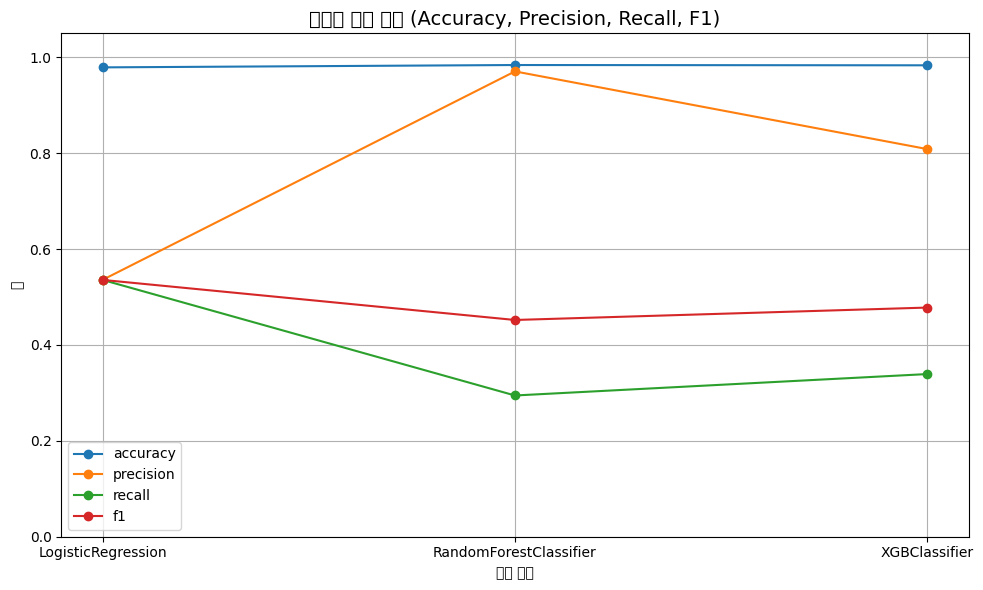

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 생성
results = [
    {'name': 'LogisticRegression', 'accuracy': '0.9790', 'precision': '0.5357', 'recall': '0.5357', 'f1': '0.5357'},
    {'name': 'RandomForestClassifier', 'accuracy': '0.9839', 'precision': '0.9706', 'recall': '0.2946', 'f1': '0.4521'},
    {'name': 'XGBClassifier', 'accuracy': '0.9833', 'precision': '0.8085', 'recall': '0.3393', 'f1': '0.4780'}
]

results_df = pd.DataFrame(results)
results_df.set_index('name', inplace=True)

# 숫자형으로 변환
results_df = results_df.astype(float)

# 꺾은선 그래프 그리기
# plt.figure(figsize=(10, 6))
# for metric in results_df.columns:
#     plt.plot(results_df.index, results_df[metric], marker='o', label=metric)

# plt.title('모델별 성능 비교 (Accuracy, Precision, Recall, F1)', fontsize=14)
# plt.xlabel('모델 이름')
# plt.ylabel('값')
# plt.ylim(0, 1.05)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/3690229622.py:43: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/3690229622.py:43: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/3690229622.py:43: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/3690229622.py:43: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/3690229622.py:43: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/i

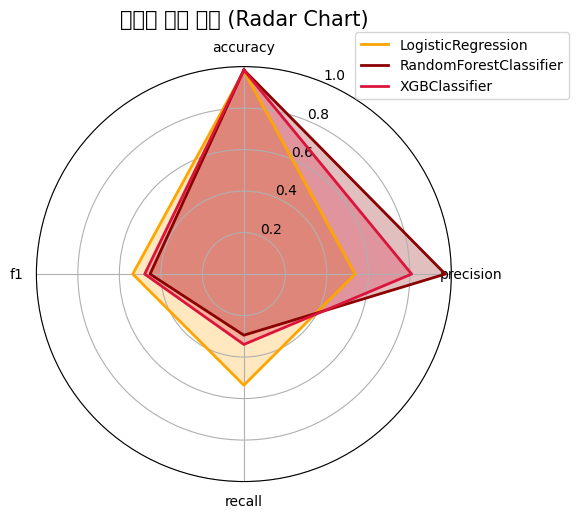

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
results = [
    {'name': 'LogisticRegression', 'accuracy': '0.9790', 'precision': '0.5357', 'recall': '0.5357', 'f1': '0.5357'},
    {'name': 'RandomForestClassifier', 'accuracy': '0.9839', 'precision': '0.9706', 'recall': '0.2946', 'f1': '0.4521'},
    {'name': 'XGBClassifier', 'accuracy': '0.9833', 'precision': '0.8085', 'recall': '0.3393', 'f1': '0.4780'}
]
results_df = pd.DataFrame(results)
results_df = results_df.set_index('name').astype(float)

# 레이더차트 설정
labels = results_df.columns.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 첫 포인트로 되돌아가기

# 차트 초기화
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
plt.title("모델별 성능 지표 (Radar Chart)", size=15, y=1.08)

# 각 모델별로 plot
colors = ['orange', 'darkred', 'crimson']
for i, (model_name, row) in enumerate(results_df.iterrows()):
    values = row.tolist()
    values += values[:1]  # 처음 값으로 되돌아가서 닫힌 도형
    ax.plot(angles, values, label=model_name, color=colors[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.25)

# 축 레이블 설정
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# 반지름 값 고정
ax.set_ylim(0, 1)

# 범례
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


✅ 1. 모델 성능 비교 분석
모델	Accuracy	Precision	Recall	F1 Score
LogisticRegression	0.9790	0.5357	0.5357	0.5357
RandomForestClassifier	0.9839	0.9706	0.2946	0.4521
XGBClassifier	0.9833	0.8085	0.3393	0.4780

📌 주요 해석:

**정확도(Accuracy)**는 모두 매우 높지만, 이탈 환자(소수 클래스) 예측이 목적이라면 단독으로 신뢰하기 어렵습니다.

LogisticRegression은 precision과 recall의 균형이 가장 좋고, f1도 가장 높음.

RandomForest는 이탈환자를 잘못 예측하지 않으려는 경향이 강함 → precision은 매우 높지만 recall이 낮음 (소극적 예측)

XGBClassifier는 그 중간.

✅ 2. 발표용 모델 선정 기준
목적	추천 모델	이유
🎯 이탈 환자 검출률(Recall) 중시	XGBClassifier	recall 33.9%로 가장 높음. 사전 경고 시스템에 적합
⚖️ 균형 잡힌 예측(F1) 중시	LogisticRegression	precision과 recall이 균형 잡혀 있고 해석 용이
⛔ 오탐 줄이기(Precision) 중시	RandomForestClassifier	높은 precision으로 불필요한 이탈 경고 줄임

💡 의료나 후속조치가 중요한 분야에서는 일반적으로:

F1-score 또는 Recall 중심의 평가가 더 적절합니다.


✅ 3. 발표용 시각화 추천
🔷 (1) 막대그래프 / 꺾은선 그래프
accuracy, precision, recall, f1을 모델별로 한눈에 비교 가능

현재 출력하신 것처럼 정량적인 비교에 매우 효과적
→ “모델별로 성능 특성이 다름” 을 설명 가능

🔷 (2) 레이더 차트
한 모델의 다중 성능 지표를 전체적으로 묘사
→ “어떤 모델이 가장 균형 잡혀 있는가?” 설명 시 효과적

✅ 결론: 어떤 모델을 쓸 것인가?
🎯 발표 목적이 "이탈 환자를 놓치지 않기 위한 사전 탐지"라면:

✅ 추천 모델: XGBClassifier

recall 33.9%는 다른 모델보다 높고,

f1도 두 번째로 높으며,

precision도 80% 수준으로 나쁘지 않음

📣 발표 표현 예시:
“이탈 환자는 놓치면 안 되는 중요한 이벤트입니다. 따라서 전체 정확도보다는 이탈 환자를 얼마나 잘 잡아내는가, 즉 **재현율(Recall)**에 집중하여 모델을 선정했습니다. 이에 따라 최종적으로 XGBoost 모델을 선택했습니다.”

/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/1966055117.py:14: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/1966055117.py:14: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/1966055117.py:14: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/1966055117.py:14: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_48636/1966055117.py:14: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ip

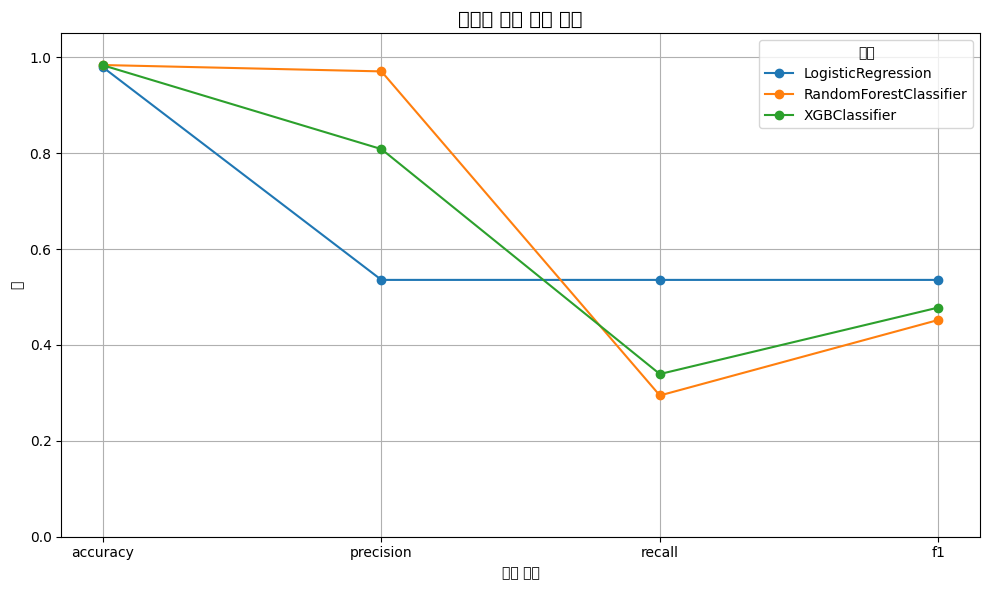

In [48]:
import matplotlib.pyplot as plt

# X축과 Y축을 전환해서 플롯
plt.figure(figsize=(10, 6))
for model in results_df.index:
    plt.plot(results_df.columns, results_df.loc[model], marker='o', label=model)

plt.title('지표별 모델 성능 비교', fontsize=14)
plt.xlabel('성능 지표')
plt.ylabel('값')
plt.ylim(0, 1.05)
plt.legend(title='모델')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# results : accuracy, precision, recall, f1 score가 포함된 딕셔너리 리스트
# pred_proba_logistic, pred_proba_randomforest, pred_pmroba_xgb : 각 모델의 예측 확률
### 모델별 결과 시각화 - 평가지표
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
### 모델별 결과 시각화 - 혼동행렬

In [ ]:
### 모델별 결과 시각화 - PR Curve, ROC Curve

In [ ]:
# 최적 모델 불러와서 predict_proba 해서 accuracy, precision, recall, f1 score 등 평가지표 보고 시각화 하고 이미지 저장까지 해야대 